# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Aprendizaje por refuerzos

### Trabajo práctico entregable 1/2 (materia completa)

**Estudiante:**
- [Chevallier-Boutell, Ignacio José.](https://www.linkedin.com/in/nachocheva/)

**Docentes:**
- Palombarini, Jorge (Mercado Libre).
- Barsce, Juan Cruz (Mercado Libre).

---

## Librerías

In [1]:
import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

Para ver los videos de las ejecuciones hay que tener instalado ffmpeg (`apt-get install ffmpeg`).

---
# Cliff walking: descripción del problema

Cliff walking es un juego que involucra moverse sobre un mapa (grilla 4x12) desde un punto inicial (Start, S) hasta un punto final (Goal, G), evitando caer por el precipicio (The Cliff).

![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

Imagen: Sutton y Barto, 2018.

Al comenzar un episodio, el jugador se ubica en el elemento [3, 0] de la grilla y debe llegar hasta el elemento [3, 11] para terminar dicho episodio. El precipio se ubica en [3, 1:11]. Cuando el jugador llega a uno de estos elementos, *se cae por el precipicio* y vuelve al punto inicial [3, 0]. El jugador debe realizar tantos movimientos como sean necesarios para llegar a la meta y finalizar el episodio.

El espacio de acciones $\mathcal{A}$ tiene 4 elementos:
- 0 $\Rightarrow$ Se mueve hacia arriba
- 1 $\Rightarrow$ Se mueve hacia la derecha
- 2 $\Rightarrow$ Se mueve hacia abajo
- 3 $\Rightarrow$ Se mueve hacia la izquierda

A pesar de que la grilla tiene 48 elementos, el jugador no puede estar en el precipicio, ya que vuelve al punto S, y tampoco puede estar en la meta, sino sólo llegar a ésta, ya que es el estado terminal del episodio. Esto resulta en que el espacio de estados $\mathcal{S}$ tiene 37 elementos. Para calcular el valor del estado asociado a cada elemento del mapa debemos calcular
    $$\text{Fila Actual} \times \text{Número de Columnas} + \text{Columna Actual}$$

donde debemos contar desde 0. De esta manera, el estado inicial es el estado 36.

Se cumple que $\mathcal{A}, \mathcal{S} \in \mathbb{N}$, teniendo al cero como primer elemento.

La función de recompensa es tal que el jugador recibe:
- $-100$ cuando cae el precipicio.
- $-1$ en todos los demás casos.

Recorrer el camino óptimo (Optimal path) requiere de 13 pasos temporales, obteniendo un retorno de -12. Por otro lado, recorrer el camino seguro (Safer path) requiere de 17 pasos temporales, obteniendo un retorno de -16.

---
# Ejercicio: SARSA + $\epsilon$-greedy

En esta actividad se implementa y ejecuta el algoritmo SARSA con una política $\epsilon$-greedy. Se estudia además el efecto de los hiperparámetros sobre la convergencia.

## Heurística de selección de acciones: política

Se define a $\epsilon$-greedy como el métodos para decidir qué acciones tomar.

In [2]:
def pol_epGreedy(
    state: int,
    actions: range,
    q: dict,
    hyperparameters: dict,
    random_state: np.random.RandomState
) -> int:

    """
    Elije una acción de acuerdo a una política de exploración-explotación 
    épsilon-greedy.
    Args:
        state: estado actual del agente
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        random_state: generador de números aleatorios
    """

    # Lista de valores q asociados a un estado-acción
    q_values = [q.get((state, a)) for a in actions]

    # Toma el valor máximo
    max_q = max(q_values)

    # Puede haber más de un valor máximo
    count = q_values.count(max_q)

    # Sortemaos un número aleatorio y comparamos con épsilon
    if random_state.uniform() < hyperparameters['epsilon']:
        # Exploramos, seleccionando una acción aleatoriamente
        return random_state.choice(actions)

    # Al no cumplirse la condición, explotamos
    elif count > 1:
        # Hay más de un valor máximo. Sorteamos alguno de ellos
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    
    else:
        # Hay un único valor máximo, eligiendo el correspondiente estado-acción
        i = q_values.index(max_q)

    return actions[i]

## Aprendizaje por diferencias temporales

Se define a SARSA como el método de aprendizaje, tomando una transición y cambiando el diccionario de los valores de Q.

In [3]:
def learn_SARSA(
    state: int,
    action: int,
    reward: int,
    next_state: int,
    next_action: int,
    hyperparameters: dict,
    q: dict
) -> Tuple[int, int]:

    """
    Realiza una actualización según el algoritmo SARSA, para una transición de 
    estado dada.
    Args:
        state: estado actual del agente
        action: acción actual ejecutada por el agente
        reward: recompensa recibida al ejecutar la acción
        next_state: próximo estado del agente
        next_action: próxima acción del agente
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        q: diccionario de valores de estado-acción
    """

    # Actualizo el valor del estado-acción
    Target = reward + hyperparameters['gamma']  * q[(next_state, next_action)]
    TD_error = Target - q[(state, action)]
    q[(state, action)] += hyperparameters['alpha'] * TD_error

    # Actualizo el estado
    state = next_state

    # Actualizo la acción
    action = next_action

    return state, action

## Iteraciones

Definimos la manera en la que itera el algoritmo.

In [4]:
def run(
    policy: Callable,
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    random_state: np.random.RandomState,
    max_iter: int
) -> Tuple[np.ndarray, np.ndarray, int, int, int, dict]:

    """
    Corre el algoritmo de RL.
    Args:
        policy: huerística de selección de acciones
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: entorno de Gymnasium
        actions: lista de acciones posibles
        random_state: generador de números aleatorios
        max_iter: cantidad máxima de pasos temporales
    """

    # Inicialización del diccionario de valores de estado-acción
    q = {}
    for s in range(49):
        for a in range(4):
            q[(s, a)] = 0.0

    # Registra la cantidad de pasos de cada episodio
    timesteps_of_episode = []

    # Registra el retorno de cada episodio
    return_of_episode = []

    # Casuísticas de finalización
    goal, drop, early = 0, 0, 0

    # Loop sobre los episodios
    for _ in range(episodes_to_run):
        # Instancea un nuevo agente en cada episodio
        # Fin del episodio: llegar a la salida o superar max_iter

        # Reinicia el entorno, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        # Retorno del episodio
        episode_return = 0

        # Contador de pasos temporales
        t = 0

        # Flag de finalización de iteración actual
        done = False

        # Elige la primera acción a ejecutar
        action = policy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # El agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Acumulamos recompensa
            episode_return += reward

            # Elige la nueva acción a ejecutar partiendo desde el nuevo estado
            next_action = policy(
                next_state, actions, q, hyperparameters, random_state)

            # Mecanismo de aprendizaje por TD
            state, action = learning_function(
                state, action, reward, next_state,next_action, hyperparameters, q)

            # Análisis de convergencia
            if terminated:
                # El agente alcanzó el objetivo
                goal += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif truncated:
                # El agente ejecutó una acción inválida
                drop += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif t >= max_iter:
                # Early stopping
                early += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            t += 1

    return timesteps_of_episode, return_of_episode, goal, drop, early, q

## Funciones de ploteo individual

Definimos funciones que permiten graficar los resulados de una única corrida.

In [5]:
def plot_return_curve(ep_return) -> None:
    '''
    Grafica la curva de convergencia suavizada.
    '''

    episode_returns = np.array(ep_return)

    episode_number = np.linspace(
        1, len(episode_returns) + 1, len(episode_returns) + 1)
    acumulated_rewards = np.cumsum(episode_returns)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Recompensa acumulada por episodio")
    axs[0].plot(reward_per_episode, color='teal', label='Agente')
    axs[0].axhline(-12, color='red', linestyle=':', label='Óptimo')
    axs[0].axhline(-16, color='blue', linestyle=':', label='Seguro')
    axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[1].plot(reward_per_episode, color='teal', label='Agente')
    axs[1].axhline(-12, color='red', linestyle=':', label='Óptimo')
    axs[1].axhline(-16, color='blue', linestyle=':', label='Seguro')
    axs[1].set_ylim(-60, -10)
    axs[1].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    plt.show()

In [6]:
def plot_learning_curve(ep_timesteps) -> None:
    '''
    Grafica la curva de aprendizaje suavizada.
    '''

    episode_steps = np.array(ep_timesteps)

    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Pasos temporales acumulados por episodio")
    axs[0].plot(steps_per_episode, color='teal', label='Agente')
    axs[0].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[0].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[0].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1].plot(steps_per_episode, color='teal', label='Agente')
    axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')
    axs[1].set_ylim(10, 60)
    plt.show()

In [7]:
def draw_value_matrix(q) -> None:
    '''
    Grafica el mapa del juego mostrando la ruta más conveniente según el
    algoritmo de aprendizaje utilizado.
    '''

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.title('Ruta más conveniente')
    plt.show()

## Funciones de ploteo comparativo

Definimos funciones que permiten graficar comparativamente los resulados de varias corridas.

## Primera implementación 

Ejecutamos una corrida de SARSA con $\epsilon$-greedy, utilizando los parámetros *por defecto* (los definidos en las consignas), tanto para los hiperparámetros como para la cantidad de episodios y de iteraciones.

El hiperparámetro $\alpha$ me determina la velocidad de convergencia. Cuando $\alpha=1$, la convergencia es muy brusca, pudiendo llegar a quedar oscilando. Al bajar el valor de $\alpha$, nos aseguramos de que eventualmente converja. Supongamos que el objetivo es juntar 50 puntos. Puede ocurrir que con $\alpha=1$ nos movamos muy rápido y terminemos oscilando en torno a un punto o puede que rápidamente llegemos a 50 puntos. Cuanto menor es el $\alpha$, más lenta será la evolución, pero eventualmente llegamos a 50 puntos.

Por otro lado, $\gamma$ nos limita el horizonte. Cuando  $\gamma=1$, dependemos exclusivamente del $\alpha$ para saber qué tan rápido o lento alcanzamos los 50 puntos. En cambio, si $0<\gamma<1$, no importa qué tan rápido o lento aprendamos, siempre habrá un techo para el valor al que convergemos, siendo menor a 50 puntos. Cuanto menor sea $\gamma$, más por debajo de 50 puntos nos vamos a encontrar.

Goal 	 Drop 	 Early 	 Total
500 	 0 	 0 	 500


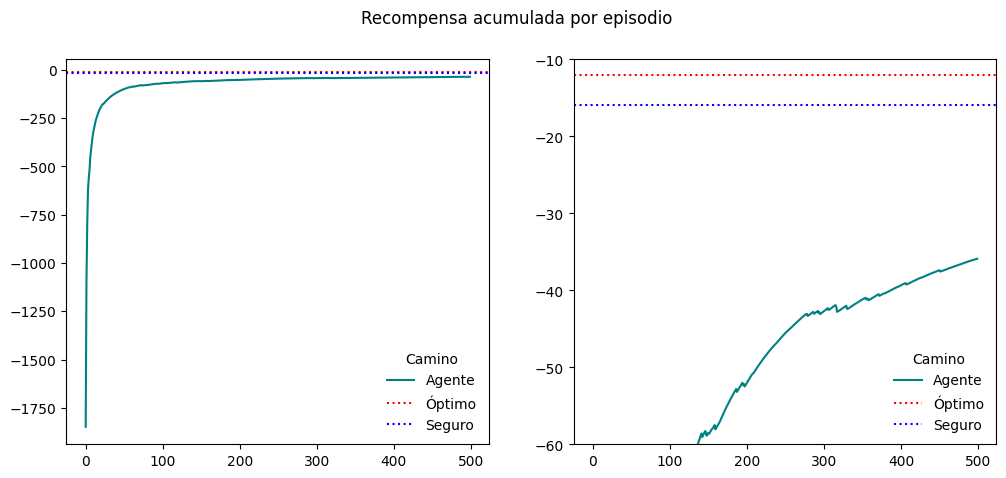

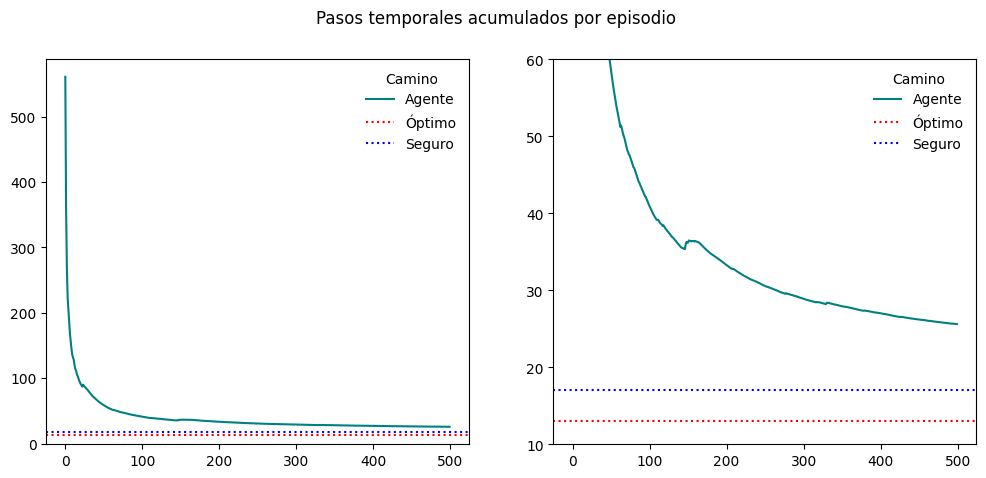

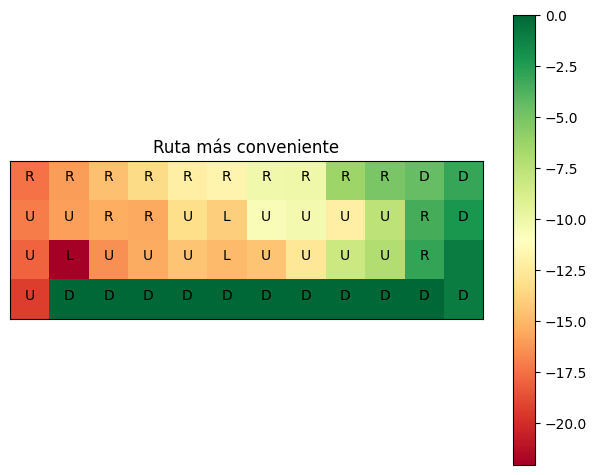

In [8]:
env = gym.make("CliffWalking-v0")#, render_mode="human")
policy = pol_epGreedy
learning_function = learn_SARSA
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1
}
episodes_to_run = 500
max_iter = 2000
random_state = np.random.RandomState(1994)
actions = range(env.action_space.n)

ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run(
    policy, 
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    random_state,
    max_iter
)

env.close()

print('Goal \t Drop \t Early \t Total')
print(f'{ep_goal} \t {ep_drop} \t {ep_early} \t {episodes_to_run}')
plot_return_curve(ep_return)
plot_learning_curve(ep_timesteps)
draw_value_matrix(q)

---
# Actividad 2

Implementar y ejecutar el algoritmo Q-Learning con una política $\epsilon$-greedy. Comparar con lo obtenido para SARSA.

---
# Actividad 3

Estudiar el efecto de los hiperparámetros sobre la convergencia de SARSA y Q-learning con una política $\epsilon$-greedy.

---
# Actividad 4

(Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

---
# Actividad 5

(Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.